In [1]:
"""nbconvert header

We are just configuring to hide some unnecessary warnings.
"""

%matplotlib inline
import arpes.config

arpes.config.DOCS_BUILD = True

Activating auto-logging. Current session state plus future input saved.
Filename       : logs/fermi-edge-correction_2024-06-05_03-41-12.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


# Performing Fermi Edge Corrections

The most straightforward way to correct the Fermi edge, either due to monochromator miscalibration in a photon energy scan or due to using a straight slit on a hemispherical analyzer is just to broadcast an edge.

In the case of correcting for the slit shape, it may be helpful to further fit a model for the edge shape, like a quadratic, so that a smooth correction is applied across the detector.

## Correcting monochromator miscalibration

In [2]:
import arpes.config
from arpes.fits import AffineBroadenedFD, broadcast_model
from arpes.io import example_data

photon_energy = example_data.photon_energy

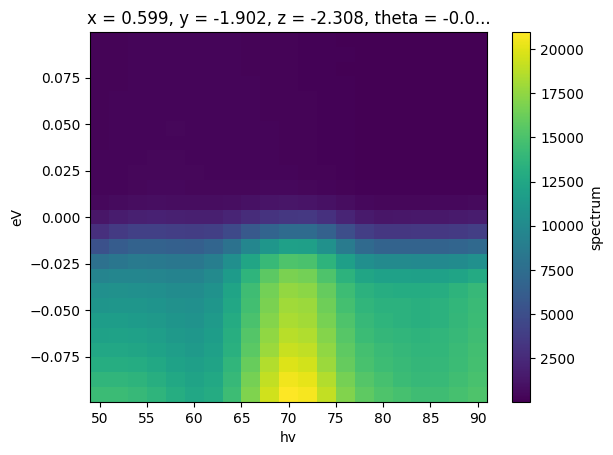

In [3]:
edge_data = photon_energy.sel(phi=slice(-0.28, -0.15), eV=slice(-0.1, 0.1)).sum("phi").spectrum
edge_data.T.plot()

/Users/arafune/src/arpes/src/arpes/fits/fit_models/fermi_edge.py:77: RuntimeWarning: overflow encountered in exp
  fermi = 1 / (np.exp(dx / fd_width) + 1)


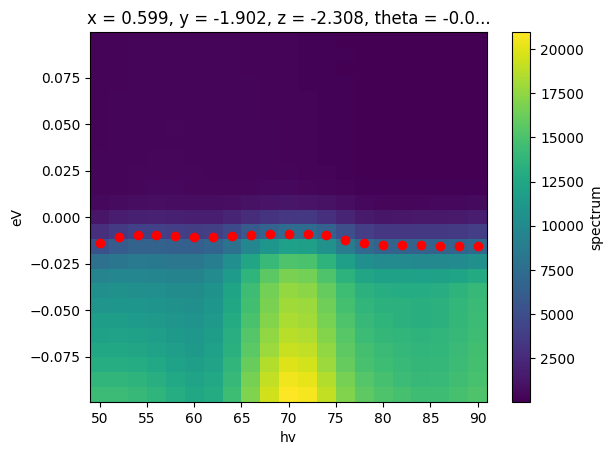

In [4]:
import matplotlib.pyplot as plt

fit_results = broadcast_model(AffineBroadenedFD, edge_data, "hv", progress=False)

fig, ax = plt.subplots()
edge_data.T.plot(ax=ax)
ax.scatter(*fit_results.results.F.p("fd_center").G.to_arrays(), color="red")

Now, we can perform the shift to correct the edge.

/Users/arafune/src/arpes/src/arpes/fits/fit_models/fermi_edge.py:77: RuntimeWarning: overflow encountered in exp
  fermi = 1 / (np.exp(dx / fd_width) + 1)


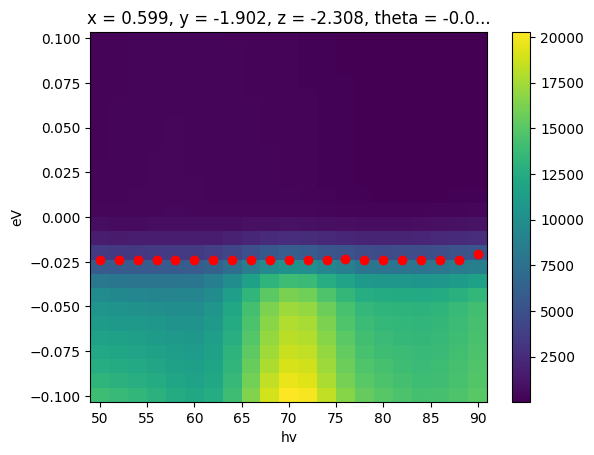

In [5]:
corrected_photon_energy = photon_energy.spectrum.G.shift_by(
    fit_results.results.F.p("fd_center"), shift_axis="eV", shift_coords=True
)  # Note that G.shift_by is applied to "spectrum" (i.e. xr.DataArray)

corrected_edge_data = corrected_photon_energy.sel(phi=slice(-0.28, -0.15), eV=slice(-0.1, 0.1)).sum(
    "phi"
)

results_check = broadcast_model(
    AffineBroadenedFD, corrected_edge_data, "hv", progress=False
)  # for suppressing the warning during Sphinx procedure.

fig, ax = plt.subplots()
corrected_edge_data.T.plot(ax=ax)
ax.scatter(*results_check.results.F.p("fd_center").G.to_arrays(), color="red")

As we can see, the edge is now uniform across photon energy and correctly zero referenced.

A caveat to be aware of when shifting data is whether to make data adjustments only or to use coordinate adjustments as well. Coordinate adjustments (above: `shift_coords=True`) are useful when the shift is very large. If the coords are not allowed to compensate for some of the shift in that context, large portions of data will be shifted out of the array extent and be replaced by `np.nan` or `0`.

However, if coordinates no longer agree between two pieces of data, we will not be able to perform array operations involving both of them, because of their incompatible coordinates. 

The correct behavior is context dependent and requires you to consider what analysis you are trying to do.

## Correcting the curved Fermi edges

Let's now turn to an example addressing the uneven energy calibration arising from the use of a straight slit in ARPES data. 

We will shortly turn to the question of momentum conversion, but we will want to have this issue corrected before converting. The correction we need to apply is a function of the detector angle `phi`, so it will not be a constant function of any momentum coordinate, in general.

First, let's assess the data.

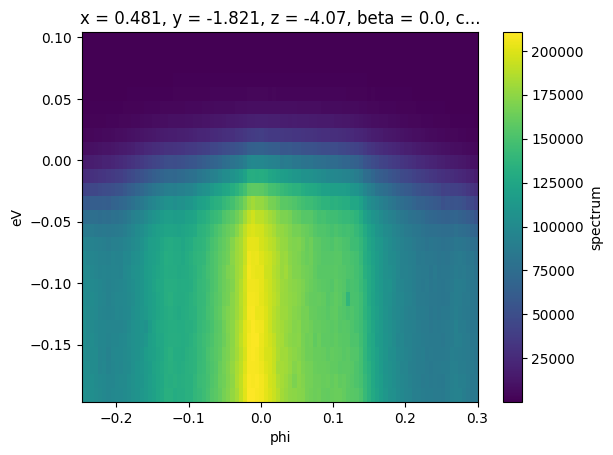

In [6]:
from arpes.io import example_data

cut = example_data.map.sum("theta").spectrum
cut = cut.sel(eV=slice(-0.2, 0.1), phi=slice(-0.25, 0.3))
cut.S.plot()

Now, let's fit edges to this data.

/Users/arafune/src/arpes/src/arpes/fits/fit_models/fermi_edge.py:77: RuntimeWarning: overflow encountered in exp
  fermi = 1 / (np.exp(dx / fd_width) + 1)
/Users/arafune/src/arpes/src/arpes/fits/fit_models/fermi_edge.py:77: RuntimeWarning: divide by zero encountered in divide
  fermi = 1 / (np.exp(dx / fd_width) + 1)
/Users/arafune/src/arpes/src/arpes/fits/fit_models/fermi_edge.py:77: RuntimeWarning: divide by zero encountered in divide
  fermi = 1 / (np.exp(dx / fd_width) + 1)
/Users/arafune/src/arpes/src/arpes/fits/fit_models/fermi_edge.py:77: RuntimeWarning: divide by zero encountered in divide
  fermi = 1 / (np.exp(dx / fd_width) + 1)
/Users/arafune/src/arpes/src/arpes/fits/fit_models/fermi_edge.py:77: RuntimeWarning: divide by zero encountered in divide
  fermi = 1 / (np.exp(dx / fd_width) + 1)


(-0.05, 0.05)

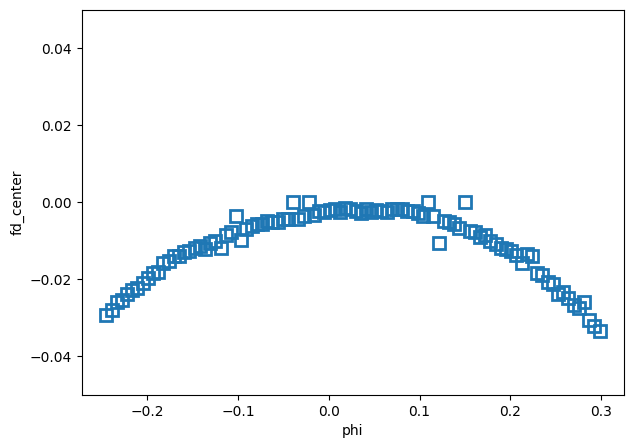

In [7]:
import matplotlib.pyplot as plt
from arpes.fits.fit_models import AffineBroadenedFD, QuadraticModel
from arpes.fits.utilities import broadcast_model

fit_results = broadcast_model(
    AffineBroadenedFD, cut, "phi", progress=False
)  # For supressing debugger warning

fit_results.results.F.plot_param("fd_center")
plt.gca().set_ylim([-0.05, 0.05])

We could either refine these fits a little by setting some constraints, or we can make a smooth correction by fitting a quadratic to these edge locations.

In [8]:
quad_mod = QuadraticModel().guess_fit(fit_results.results.F.p("fd_center"))
quat_mode_plot = quad_mod.plot()

Now, we can shift the data exactly like we did before. In order to get the shift amount to apply at each `phi`, we just evaluate our quadratic at these `phi`.

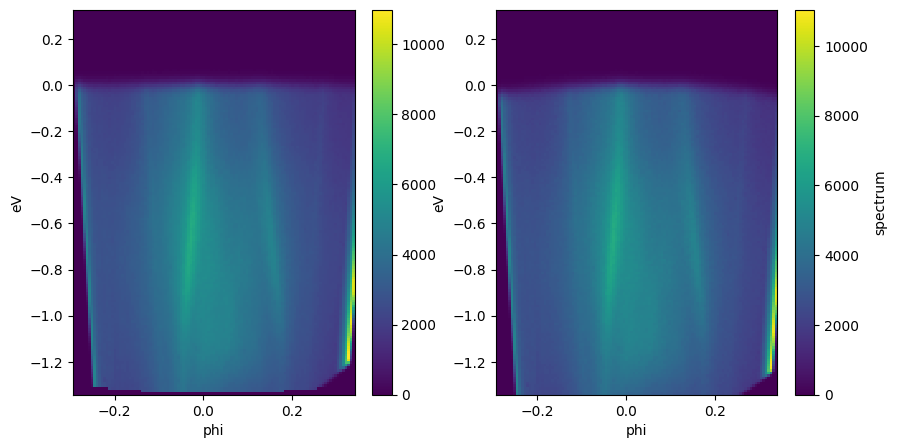

In [9]:
fmap = example_data.map.spectrum
edge = quad_mod.eval(x=fmap.phi)

corrected_map = fmap.G.shift_by(edge, shift_axis="eV", by_axis="phi")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
corrected_map.isel(theta=10).S.plot(ax=axes[0])
fmap.isel(theta=10).S.plot(ax=axes[1])

for ax in axes:
    ax.set_title("")

Much better. With this in order, we can now consider momentum conversion.

## Exercises

1. Correct the Fermi edge on the Bi2Se3 cut data `example_data.cut`. How does the presence of the dispersing surface state affect the range you should use?
2. Perform a random shift of a Fermi edge using `.G.shift_by`. Then, try to correct it. How close is your recovered correction to the original shift?